## GB_FX Macro Monthly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'dI_t', 'd_pi', 'Q']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<400
  2000-03: hist<400
  2000-04: hist<400
  2000-05: hist<400
  2000-06: hist<400
  2000-07: hist<400
  2000-08: hist<400
  2000-09: hist<400
  2000-10: hist<400
  2000-11: hist<400
  2000-12: hist<400
  2001-01: hist<400
  2001-02: hist<400
  2001-03: hist<400

=== Model performance (monthly mean, EUR/NOK – GB past macro covariates) ===
Observations: 296
RMSE (level): 0.164386
MAE  (level): 0.107797
Directional accuracy: 200/295 (67.8%)

=== Diebold–Mariano vs Random Walk (GB past macro covariates, monthly) ===
Loss: MSE | horizon h=1
DM-statistic: -0.1843
p-value     : 0.8538


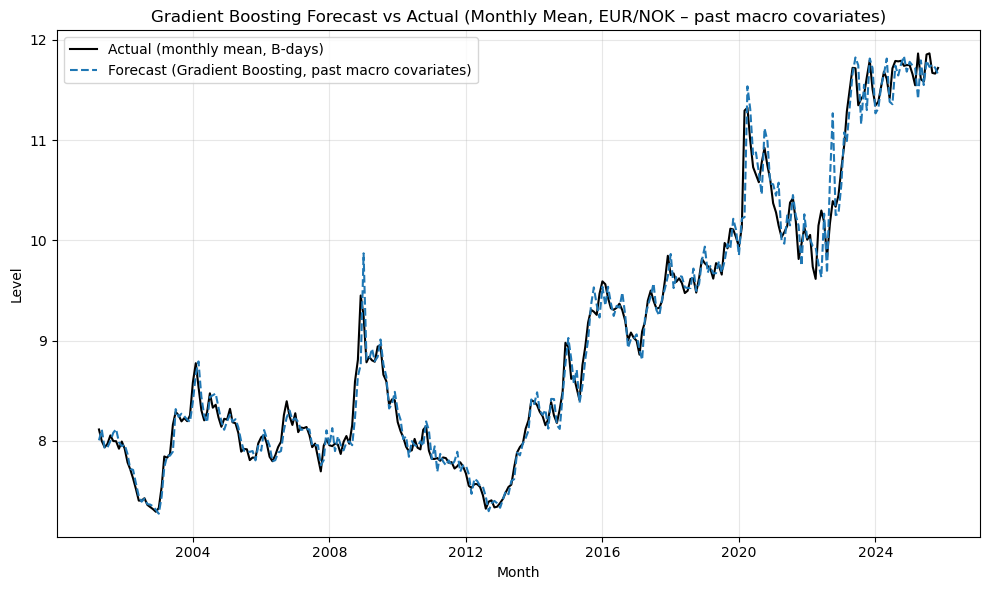

Saved: GB_M_daily_pastcov.png
Saved: GB_M_daily_pastcov.pdf


In [3]:
# =========================================
# Gradient Boosting – EUR/NOK walk-forward (monthly, levels) with daily macro covariates
# PARALLEL OUTER LOOP
# Univariate setup:
#   - Target: EUR_NOK (single series)
#   - Macros: Q, d_pi, dI_t as past-only covariates
#   - Data: daily (calendar days), forward-filled
#   - Cut: last business day of previous month (based on EUR_NOK B-days)
#   - Forecast: next calendar month at daily frequency (recursive one-step GB),
#               aggregated to monthly mean over business days (EUR/NOK)
#   - No future macro paths used -> macros are frozen at last observed value during recursion
#   - Metrics: Observations, RMSE, MAE, Directional accuracy
#   - Test: Diebold–Mariano vs Random Walk (MSE, h=1)
#   - Plot: Actual (black) vs Forecast (blue dashed), no intervals
# =========================================

!pip -q install pandas numpy scikit-learn matplotlib requests certifi joblib

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 400   # GB + macros need more history to stabilize
    max_lags: int = 20         # Number of daily lags per variable

    # Gradient Boosting hyperparameters
    n_estimators: int = 800
    learning_rate: float = 0.03
    max_depth: int = 3
    subsample: float = 0.8
    min_samples_leaf: int = 2
    random_state: int = 42

    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "GB_M_daily_pastcov.png"
    fig_pdf: str = "GB_M_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cuts and monthly ground truth)
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t],
             calendar days, forward-filled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", "EUR_NOK", "Q", "d_pi", "dI_t"}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types
    for col in [TARGET_SERIES] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=[TARGET_SERIES])

    # Business-day EUR_NOK (truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Feature engineering (multivariate lags)
# -----------------------------
def make_lag_matrix(df_hist: pd.DataFrame, max_lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Build X, y_target for one-step ahead daily forecasting.

    For each t:
      X_t = [EUR_NOK_{t-1..t-L}, Q_{t-1..t-L}, d_pi_{t-1..t-L}, dI_t_{t-1..t-L}]
      y_target = EUR_NOK_t
    """
    work = df_hist[[TARGET_SERIES] + MACRO_COLS].copy()
    lag_cols: List[str] = []

    for var in [TARGET_SERIES] + MACRO_COLS:
        for k in range(1, max_lags + 1):
            name = f"{var}_lag{k}"
            work[name] = work[var].shift(k)
            lag_cols.append(name)

    work = work.dropna()
    X = work[lag_cols].values
    y_target = work[TARGET_SERIES].values
    return X, y_target

# -----------------------------
# Gradient Boosting one-step model
# -----------------------------
def fit_gb_one_step(df_hist_daily: pd.DataFrame) -> GradientBoostingRegressor:
    """Fit GB for one-step ahead daily prediction using lagged target + lagged macros."""
    X, y_target = make_lag_matrix(df_hist_daily, CFG.max_lags)
    model = GradientBoostingRegressor(
        n_estimators=CFG.n_estimators,
        learning_rate=CFG.learning_rate,
        max_depth=CFG.max_depth,
        subsample=CFG.subsample,
        min_samples_leaf=CFG.min_samples_leaf,
        random_state=CFG.random_state,
    )
    model.fit(X, y_target)
    return model

def recursive_daily_forecast(model: GradientBoostingRegressor, df_hist_daily: pd.DataFrame, H: int) -> pd.Series:
    """
    Produce H daily forecasts recursively.

    Anti-leakage rule:
      - Macros are past-only covariates.
      - During recursion we freeze macro values at their last observed level.
    """
    hist = df_hist_daily[[TARGET_SERIES] + MACRO_COLS].copy()

    # Last observed macro levels (frozen into the future)
    last_macros = hist[MACRO_COLS].iloc[-1].to_dict()

    preds = []
    for _ in range(H):
        if len(hist) < CFG.max_lags:
            raise ValueError("Not enough history for lag features.")

        # Build one-step feature vector using the last L lags of each variable
        row_feats = []
        for var in [TARGET_SERIES] + MACRO_COLS:
            lags = hist[var].iloc[-CFG.max_lags:][::-1].values  # [t-1, ..., t-L]
            row_feats.extend(lags.tolist())

        x = np.array(row_feats, dtype=float).reshape(1, -1)
        yhat = float(model.predict(x)[0])
        preds.append(yhat)

        # Append predicted target; append frozen macros
        new_row = {TARGET_SERIES: yhat}
        for mc in MACRO_COLS:
            new_row[mc] = last_macros[mc]

        hist = pd.concat(
            [hist, pd.DataFrame([new_row], index=[hist.index[-1] + pd.Timedelta(days=1)])]
        )

    return pd.Series(preds)

# -----------------------------
# Monthly walk-forward using GB + past macros (PARALLEL outer loop)
# -----------------------------
def walk_forward_gb_monthly_pastcov_parallel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    n_jobs_outer: int = -1,
    backend: str = "loky"
) -> pd.DataFrame:
    """
    For each calendar month m:
      - cut at last business day of previous month
      - fit GB on daily history up to cut (EUR_NOK + macros)
      - recursively forecast full next month at daily frequency
      - aggregate to business-day monthly mean and compare to truth

    Outer loop is parallelized: each month is computed independently.
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    def _process_one_month(m: pd.Period):
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            return (str(m), None, "no_cut_in_prev_month")

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            return (str(m), None, f"hist<{CFG.min_hist_days}")

        # Business days in the target month
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            return (str(m), None, "no_bdays_in_month")
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horizon = full calendar month length (inclusive)
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0:
            return (str(m), None, f"horizon_invalid(H={H})")

        # Fit GB and forecast recursively
        model = fit_gb_one_step(hist_df)
        pf = recursive_daily_forecast(model, hist_df, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf.values, index=f_idx, name="point")

        # Aggregate forecast to business-day mean
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            return (str(m), None, "no_overlap_pred_B_days")
        y_pred = float(pred_b.dropna().mean())

        row = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}
        return (str(m), row, None)

    results = Parallel(n_jobs=n_jobs_outer, backend=backend)(
        delayed(_process_one_month)(m) for m in months
    )

    rows: Dict[str, dict] = {}
    dropped: Dict[str, str] = {}

    for key, row, reason in results:
        if row is not None:
            rows[key] = row
        else:
            dropped[key] = reason or "unknown"

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if str(m) not in rows]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – GB past macro covariates) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse"
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark = previous month's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (GB past macro covariates, monthly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (monthly mean)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(
        x, eval_df["y_pred"],
        color="tab:blue", linestyle="--",
        label="Forecast (Gradient Boosting, past macro covariates)"
    )

    plt.title("Gradient Boosting Forecast vs Actual (Monthly Mean, EUR/NOK – past macro covariates)")
    plt.xlabel("Month")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Monthly walk-forward and evaluation (parallel outer loop)
    df_eval = walk_forward_gb_monthly_pastcov_parallel(S_b, DF_d, n_jobs_outer=-1)
    eval_df = evaluate(df_eval)

    # 3) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 4) Plot
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
